# Medical Provider Fraud Detection Analysis

In [5]:
# import libraries 
!pip install xgboost

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [6]:
newpath = r'figures' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [7]:
# read datasets 
train_out = pd.read_csv('data/Train_Outpatientdata.csv')
train_in = pd.read_csv('data/Train_Inpatientdata.csv')
train_ben = pd.read_csv('data/Train_Beneficiarydata.csv')
train_label = pd.read_csv('data/Train.csv')

train_out = train_out.merge(train_ben, on='BeneID', how='inner')
train_out = train_out.merge(train_label, on='Provider', how='inner')

train_in = train_in.merge(train_ben, on='BeneID', how='inner')
train_in = train_in.merge(train_label, on='Provider', how='inner')

# convert output label to binary 
train_out['Label'] = np.where(train_out['PotentialFraud'] == 'Yes', 1, 0)
train_out.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,Label
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,2,2,2,2,0,0,30,50,Yes,1
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,1,1,1,2,0,0,1810,760,Yes,1
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,1,1,1,2,0,0,1810,760,Yes,1
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,...,1,1,1,2,0,0,1810,760,Yes,1
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,V6546,...,1,1,1,2,0,0,1810,760,Yes,1


In [8]:
train_out.shape

(517737, 53)

In [9]:
# examine potential fraud rows 
train_in['Label'] = np.where(train_in['PotentialFraud'] == 'Yes', 1, 0)
train_in.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,Label
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,2,1,1,36000,3204,60,70,Yes,1
1,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,...,1,2,2,2,19000,1068,100,20,Yes,1
2,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,...,1,1,2,2,17000,1068,1050,540,Yes,1
3,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,...,1,1,1,2,27000,2136,450,160,Yes,1
4,BENE24402,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,...,1,2,2,2,3000,1068,8900,740,Yes,1


In [10]:
# encode indicator for outpatient and join datasets
train_out['Outpatient'] = 1
train_in['Outpatient'] = 0
full_train = train_out.append(train_in)
full_train.head()

/tmp/ipykernel_263/1783487176.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_train = train_out.append(train_in)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,Label,Outpatient,AdmissionDt,DischargeDt,DiagnosisGroupCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,0,0,30,50,Yes,1,1,NaN,NaN,NaN
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,0,0,1810,760,Yes,1,1,NaN,NaN,NaN
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,0,0,1810,760,Yes,1,1,NaN,NaN,NaN
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,...,0,0,1810,760,Yes,1,1,NaN,NaN,NaN
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,V6546,...,0,0,1810,760,Yes,1,1,NaN,NaN,NaN


# EDA

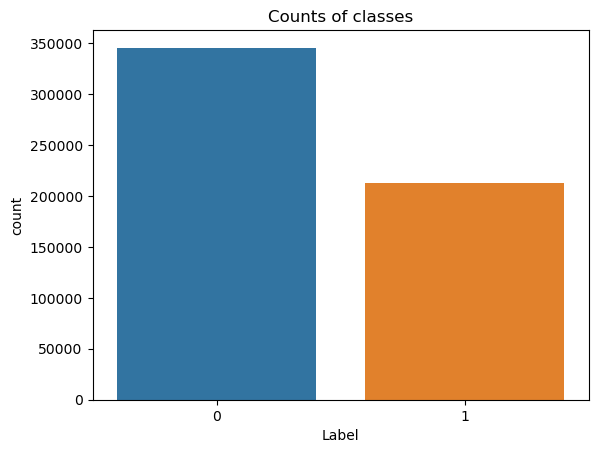

In [13]:
# plot counts of label classes
sns.countplot(data=full_train, x='Label');
plt.title('Counts of classes');
plt.savefig('figures/class_counts');

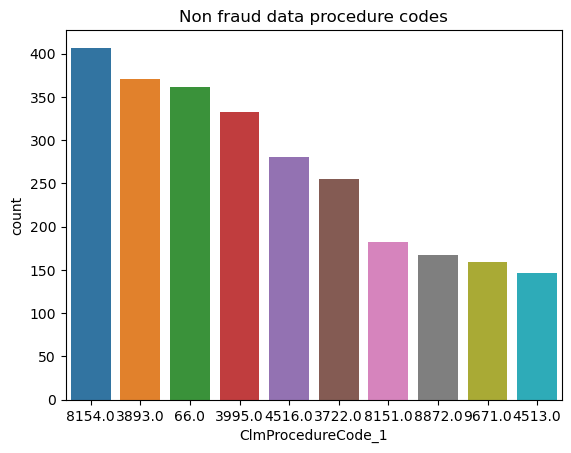

In [14]:
# subset datasets of fraud and non fraud
train_nofraud = full_train[full_train['Label']==0]
train_fraud = full_train[full_train['Label']==1]

# plot counts of top appearing procodure codes for non fraud data
sns.countplot(x='ClmProcedureCode_1', data=train_nofraud, order=train_nofraud['ClmProcedureCode_1'].value_counts().sort_values(ascending=False).index[1:11])

plt.title('Non fraud data procedure codes');
plt.savefig('figures/nonfraud_procedure_codes');

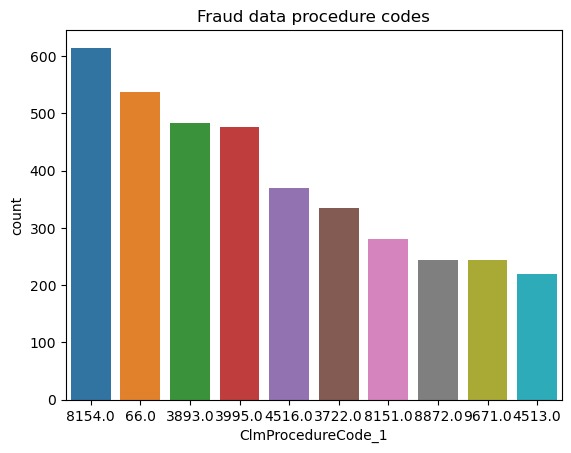

In [15]:
# plot counts of top appearing procedure codes for fraud data
sns.countplot(x='ClmProcedureCode_1', data=train_fraud, order=train_fraud['ClmProcedureCode_1'].value_counts().sort_values(ascending=False).index[1:11])
plt.title('Fraud data procedure codes');
plt.savefig('figures/fraud_procedure_codes');

In [16]:
# extract important claim codes, which are the unique codes found in the graphs above plus up to the 25th most common code
important_clm_codes = np.unique(np.append(train_fraud['ClmProcedureCode_1'].value_counts().index[1:25], train_nofraud['ClmProcedureCode_1'].value_counts().index[1:25]))

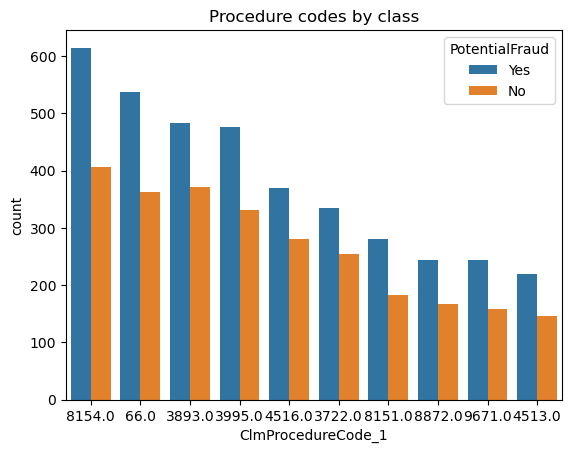

In [17]:
# plot counts of top appearing procedure codes with side by side bars for fraud vs non fraud
sns.countplot(x='ClmProcedureCode_1',hue='PotentialFraud',data=full_train, order=full_train['ClmProcedureCode_1'].value_counts().index[1:11]);
plt.title('Procedure codes by class');
plt.savefig('figures/class_procedure_codes');
# code 9904 - transfusion of packed cells
# code 4516 - EGD

In [18]:
# examine other providers who give the same procedure codes of 8154
out_8154 = full_train.loc[full_train['ClmProcedureCode_1'] == 8154.0]
out_8154['Provider'].value_counts()[:5]

PRV52019    16
PRV53808    10
PRV53706    10
PRV55462    10
PRV51146     8
Name: Provider, dtype: int64

In [19]:
# identify if most frequent providers under this code are fraudulent
print(train_label.loc[train_label['Provider']=='PRV52019'])
print(train_label.loc[train_label['Provider']=='PRV53808'])
print(train_label.loc[train_label['Provider']=='PRV53706'])

     Provider PotentialFraud
818  PRV52019            Yes
      Provider PotentialFraud
2258  PRV53808            Yes
      Provider PotentialFraud
2176  PRV53706            Yes


In [20]:
out_8154['Provider'].value_counts()[-5:]

PRV52687    1
PRV54566    1
PRV55912    1
PRV52459    1
PRV53159    1
Name: Provider, dtype: int64

In [21]:
# identify if least frequent providers under this code are fraudulent
print(train_label.loc[train_label['Provider']=='PRV55912'])
print(train_label.loc[train_label['Provider']=='PRV52459'])
print(train_label.loc[train_label['Provider']=='PRV53159'])

      Provider PotentialFraud
3928  PRV55912            Yes
      Provider PotentialFraud
1169  PRV52459             No
      Provider PotentialFraud
1731  PRV53159             No


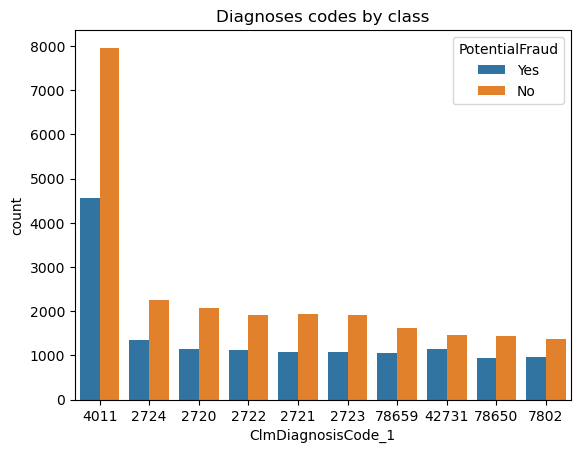

In [22]:
# plot counts of top appearing diagnoses codes with side by side bars for fraud vs non fraud
sns.countplot(x='ClmDiagnosisCode_1',hue='PotentialFraud',data=full_train, order=full_train['ClmDiagnosisCode_1'].value_counts().index[1:11]);
plt.title('Diagnoses codes by class');
plt.savefig('figures/class_diagnosis_codes');

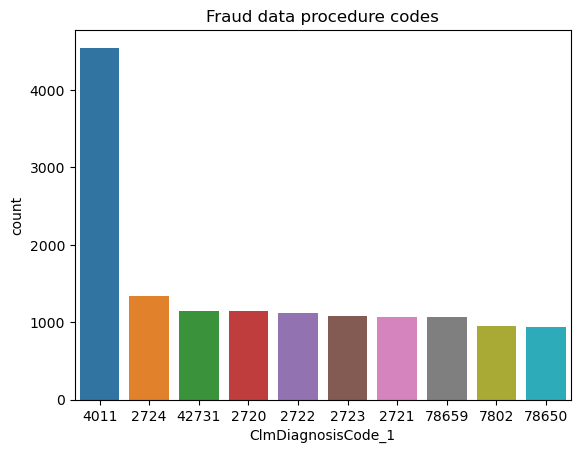

In [23]:
# plot counts of top appearing diagnoses codes for fraud data
sns.countplot(x='ClmDiagnosisCode_1', data=train_fraud, order=train_fraud['ClmDiagnosisCode_1'].value_counts().sort_values(ascending=False).index[1:11]);
plt.title('Fraud data procedure codes');
plt.savefig('figures/fraud_diagnosis_codes');

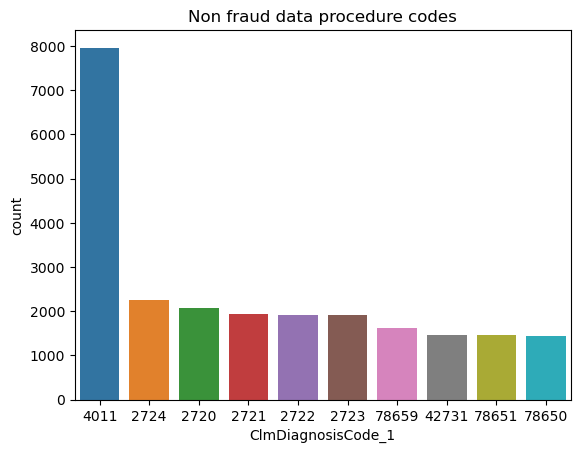

In [24]:
# plot counts of top appearing diagnoses codes for non fraud data
sns.countplot(x='ClmDiagnosisCode_1', data=train_nofraud, order=train_nofraud['ClmDiagnosisCode_1'].value_counts().sort_values(ascending=False).index[1:11]);
plt.title('Non fraud data procedure codes');
plt.savefig('figures/nonfraud_diagnosis_codes');

In [25]:
# extract important diagnoses codes, which are the unique codes found in the graphs above plus up to the 25th most common code
important_diag_codes = np.unique(np.append(train_fraud['ClmDiagnosisCode_1'].value_counts().index[1:25], train_nofraud['ClmDiagnosisCode_1'].value_counts().index[1:25]))

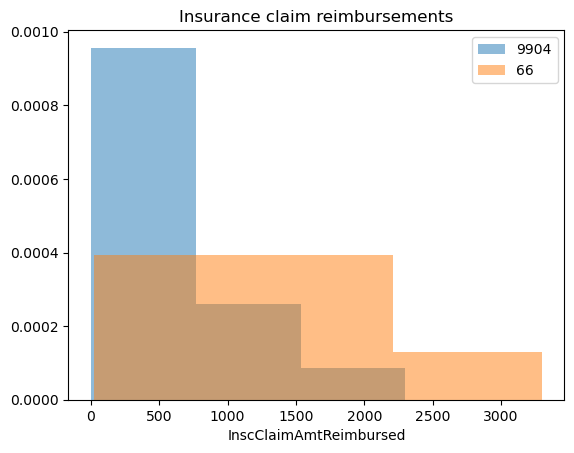

In [26]:
# examine insurance data for 9904 and 66
plt.hist(train_out[train_out['ClmProcedureCode_1']==9904]['InscClaimAmtReimbursed'], bins = 3, alpha=0.5, label='9904', density=True)
plt.hist(train_out[train_out['ClmProcedureCode_1']==66]['InscClaimAmtReimbursed'], bins = 3, alpha=0.5, label='66', density=True)
plt.legend();
plt.xlabel('InscClaimAmtReimbursed');
plt.title('Insurance claim reimbursements');
plt.savefig('figures/insurance_claims_by_provider');

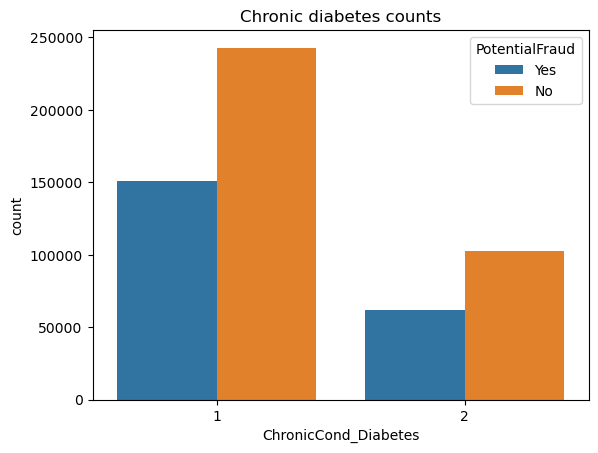

In [27]:
# examine differences in chronic diabetes indicators between classes
sns.countplot(x='ChronicCond_Diabetes',hue='PotentialFraud',data=full_train);
plt.title('Chronic diabetes counts');
plt.savefig('figures/chronic_diabetes_by_class');

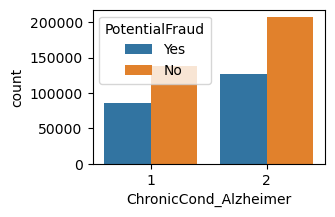

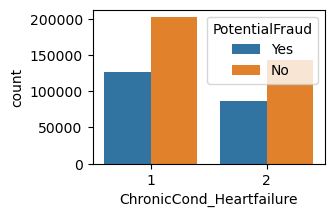

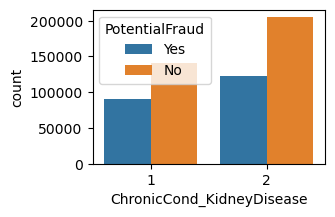

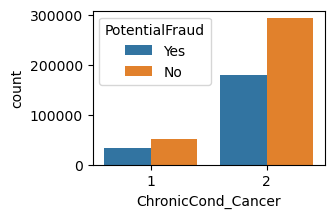

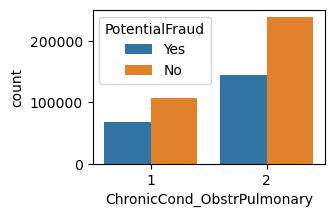

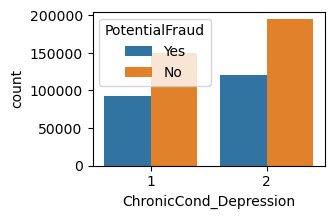

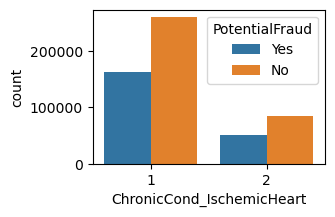

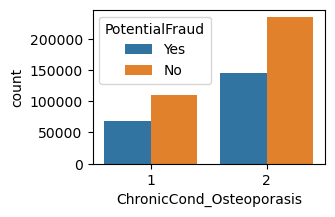

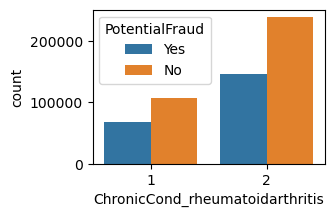

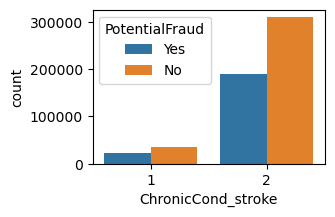

In [40]:
# repeat for other diseases
diseases = ['ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

for i in diseases:
    plt.figure(figsize=(3,2));
    sns.countplot(x=i,hue='PotentialFraud',data=full_train);
    plt.show();


# Preprocessing

In [54]:
# check which columns have null values
# diagnoses and procedure codes are indicators, so data points with no 7th code for example, are null in the 7th code column
full_train.isnull().sum()

BeneID                                  0
ClaimID                                 0
ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                   1508
OperatingPhysician                 443764
OtherPhysician                     358475
ClmDiagnosisCode_1                  10453
ClmDiagnosisCode_2                 195606
ClmDiagnosisCode_3                 315156
ClmDiagnosisCode_4                 393675
ClmDiagnosisCode_5                 446287
ClmDiagnosisCode_6                 473819
ClmDiagnosisCode_7                 492034
ClmDiagnosisCode_8                 504767
ClmDiagnosisCode_9                 516396
ClmDiagnosisCode_10                553201
ClmProcedureCode_1                 534901
ClmProcedureCode_2                 552721
ClmProcedureCode_3                 557242
ClmProcedureCode_4                 558093
ClmProcedureCode_5                

In [55]:
# removed deceased patients 
full_train = full_train[pd.isnull(full_train['DOD'])]

In [56]:
# create new features 

# extract admissions and discharge dataes; extract dob and dod 
full_train['AdmissionDt'] = pd.to_datetime(full_train['AdmissionDt'])  
full_train['DischargeDt'] = pd.to_datetime(full_train['DischargeDt'])  
full_train['DOB'] = pd.to_datetime(full_train['DOB'])  
full_train['DOD'] = pd.to_datetime(full_train['DOD'])  

# compute stay duration = discharge - admission 
full_train['StayDuration'] = (full_train['DischargeDt'] - full_train['AdmissionDt']).dt.days
full_train['StayDuration'].fillna(0.0)

# compute age of patient
today = datetime(2023, 1, 1)
full_train['DOD'].fillna(today)
full_train['Age'] = ((today - full_train['DOB']).dt.days)/365

# one hot encode race variables
full_train = full_train.join(pd.get_dummies(full_train['Race'], drop_first=True))
full_train = full_train.rename(columns={2: "Race1", 3: "Race2", 5: "Race3"})

full_train = full_train.fillna(0)
full_train = full_train.drop_duplicates()

In [57]:
# encode significant diagnoses and procedure codes extracted from earlier
for code in important_clm_codes: 
    full_train['Clm'+str(code)] = 0
    full_train.loc[full_train['ClmProcedureCode_1'].astype(float) == code, 'Clm'+str(code)] = 1

for code in important_diag_codes:
    full_train['Diag'+str(code)] = 0
    full_train.loc[full_train['ClmDiagnosisCode_1'] == code, 'Diag'+str(code)] = 1

# Additional EDA

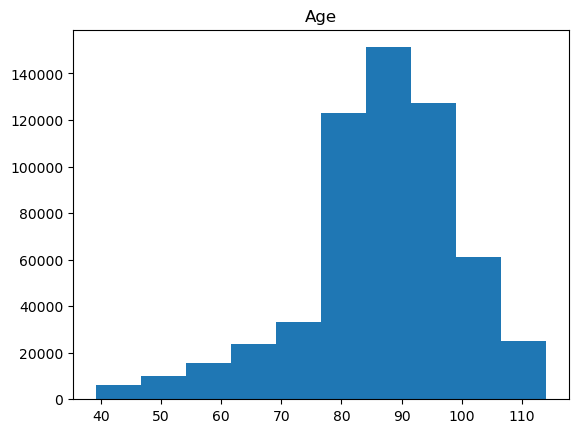

In [58]:
# plot age distribution
plt.hist(full_train['Age'], bins=10);
plt.title('Age');
plt.savefig('figures/age_dist');

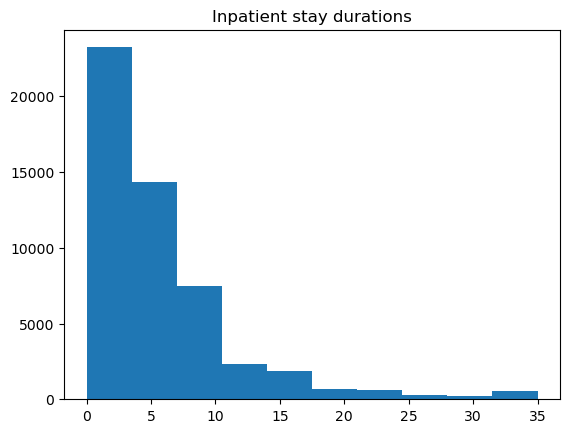

In [62]:
# plot the distribution of stay duration for inpatients 
plt.hist(full_train[full_train['Outpatient']==0]['StayDuration'], bins=10);
plt.title('Inpatient stay durations');
plt.savefig('figures/inpatient_stayduration');

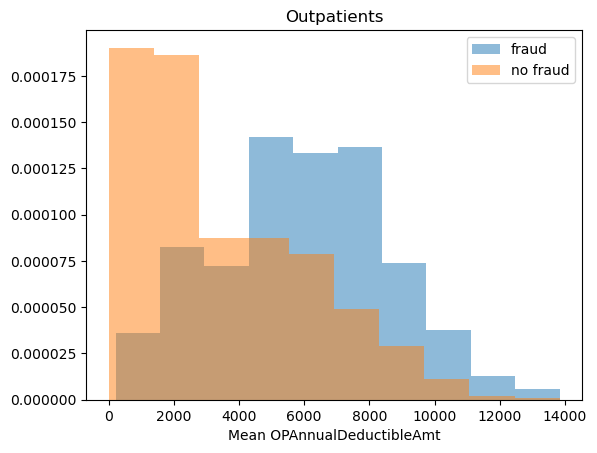

In [37]:
# determine differences between maximum annual deductible amounts per provider for outpatients
out_data = full_train[full_train['Outpatient']==1]
in_data = full_train[full_train['Outpatient']==0]

plt.hist(train_fraud.groupby('Provider').agg('max', numeric_only=True)['OPAnnualDeductibleAmt'], density=True, bins=10, label='fraud', alpha=0.5);
plt.hist(train_nofraud.groupby('Provider').agg('max', numeric_only=True)['OPAnnualDeductibleAmt'], density=True, bins=10, label='no fraud', alpha=0.5);
plt.legend();
plt.xlabel('Mean OPAnnualDeductibleAmt');
plt.title('Outpatients');
plt.savefig('figures/class_outpatient_deductibles');

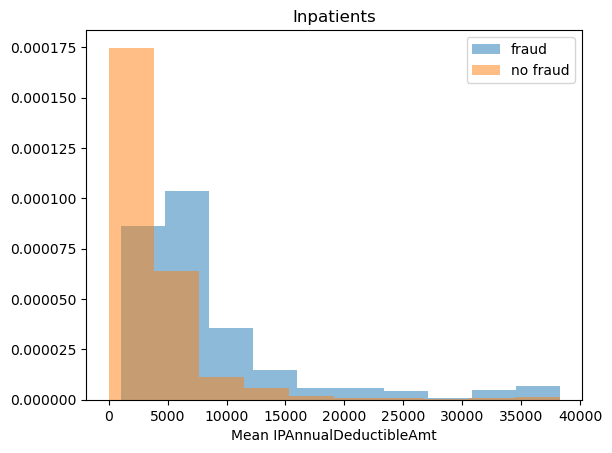

In [38]:
# determine differences between maximum annual deductible amounts per provider for inpatients
plt.hist(train_fraud.groupby('Provider').agg('max', numeric_only=True)['IPAnnualDeductibleAmt'], density=True, bins=10, label='fraud', alpha=0.5);
plt.hist(train_nofraud.groupby('Provider').agg('max', numeric_only=True)['IPAnnualDeductibleAmt'], density=True, bins=10, label='no fraud',  alpha=0.5);
plt.legend();
plt.xlabel('Mean IPAnnualDeductibleAmt');
plt.title('Inpatients');
plt.savefig('figures/class_inpatient_deductibles');

# Models

In [65]:
full_train.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1',
       ...
       'Diag7802', 'Diag78079', 'Diag7850', 'Diag78650', 'Diag78651',
       'Diag78659', 'Diag79029', 'Diag7915', 'DiagV4585', 'DiagV5789'],
      dtype='object', length=120)

In [89]:
full_train.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,Diag7802,Diag78079,Diag7850,Diag78650,Diag78651,Diag78659,Diag79029,Diag7915,DiagV4585,DiagV5789
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,0,0,78943,...,0,0,0,0,0,0,0,0,0,0
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,0,0,1970,...,0,0,0,0,0,0,0,0,0,0
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,0,0,71988,...,0,0,0,0,0,0,0,0,0,0
1,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,4240,...,0,0,0,0,0,0,0,0,0,0
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,0,0,82382,...,0,0,0,0,0,0,0,0,0,0


In [63]:
# save processed data as csv
full_train.to_csv('data/full_train.csv')

In [3]:
full_train = pd.read_csv('data/full_train.csv')

/tmp/ipykernel_35511/1231026081.py:1: DtypeWarning: Columns (55,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  full_train = pd.read_csv('data/full_train.csv')


In [66]:
# extracts needed columns  
columns = ['InscClaimAmtReimbursed','Gender', 'Race',
       'RenalDiseaseIndicator', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt',
       'Outpatient', 'StayDuration', 'Age', 'Race1', 'Race2', 'Race3',
        'Clm66.0', 'Clm309.0', 'Clm387.0', 'Clm3491.0', 'Clm3722.0',
       'Clm3772.0', 'Clm3812.0', 'Clm3893.0', 'Clm3950.0', 'Clm3995.0',
       'Clm4513.0', 'Clm4516.0', 'Clm4523.0', 'Clm4525.0', 'Clm5123.0',
       'Clm7935.0', 'Clm8108.0', 'Clm8151.0', 'Clm8152.0', 'Clm8154.0',
       'Clm8622.0', 'Clm8872.0', 'Clm9339.0', 'Clm9390.0', 'Clm9671.0',
       'Clm9672.0', 'Clm9921.0', 'Diag185', 'Diag25000', 'Diag2720',
       'Diag2721', 'Diag2722', 'Diag2723', 'Diag2724', 'Diag4011', 'Diag41401',
       'Diag4271', 'Diag42731', 'Diag42732', 'Diag42761', 'Diag42769',
       'Diag42781', 'Diag42789', 'Diag4279', 'Diag4280', 'Diag486',
       'Diag49121', 'Diag5990', 'Diag7802', 'Diag78079', 'Diag7850',
       'Diag78650', 'Diag78651', 'Diag78659', 'Diag79029', 'Diag7915',
       'DiagV4585', 'DiagV5789']

# examine format of renal disease indicator
# we need to change the data type to binary 
full_train[columns]['RenalDiseaseIndicator']

0         0
0         0
1         0
1         0
2         0
         ..
517732    0
517733    0
517734    Y
517735    0
517736    0
Name: RenalDiseaseIndicator, Length: 576892, dtype: object

In [67]:
full_train.loc[ full_train['RenalDiseaseIndicator'] == 'Y', 'RenalDiseaseIndicator'] = 1
full_train.loc[ full_train['RenalDiseaseIndicator'] == '0', 'RenalDiseaseIndicator'] = 1
full_train['RenalDiseaseIndicator'] = pd.to_numeric(full_train['RenalDiseaseIndicator'])
X = full_train[columns]
y = full_train['Label']
print(X.shape)
print(y.shape)

(576892, 85)
(576892,)


In [68]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# run logistic regression model 
logreg = LogisticRegression(random_state=0).fit(X_train, y_train)
logreg_preds = logreg.predict(X_train)

logreg.score(X_train, y_train)

0.612790640515165

In [69]:
precision_recall_fscore_support(y_train, logreg_preds, average='macro')

(0.596114012610212, 0.5112201309528445, 0.4168442562904217, None)

In [70]:
# run XGB model
xgb = XGBClassifier().fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
accuracy = accuracy_score(y_train, xgb_preds)

print(accuracy)
precision_recall_fscore_support(y_train, xgb_preds, average='macro')

0.6484320223948753


(0.6636078712614792, 0.5670217458086403, 0.532068867086258, None)

In [71]:
xgb.feature_importances_

array([0.00301764, 0.0057448 , 0.02310552, 0.        , 0.00734336,
       0.00748396, 0.00444438, 0.00527155, 0.00603878, 0.00670653,
       0.00550945, 0.00505546, 0.00681966, 0.0060608 , 0.00574101,
       0.0053408 , 0.00626117, 0.00704238, 0.00627573, 0.00759116,
       0.00729634, 0.52199924, 0.00450046, 0.00680438, 0.01377445,
       0.03164336, 0.08733736, 0.00416843, 0.00099949, 0.00648509,
       0.00366424, 0.00691677, 0.00095474, 0.00217769, 0.00395649,
       0.0073159 , 0.00438763, 0.00303693, 0.00499028, 0.00141141,
       0.        , 0.00386711, 0.        , 0.        , 0.00466174,
       0.        , 0.00279162, 0.00627664, 0.00292558, 0.00067327,
       0.00524675, 0.00420371, 0.00295653, 0.00535565, 0.00250856,
       0.00314964, 0.00452129, 0.0075383 , 0.00540689, 0.00337204,
       0.0057355 , 0.003618  , 0.00253147, 0.        , 0.00443332,
       0.00392887, 0.        , 0.00067841, 0.00378395, 0.00247373,
       0.00657987, 0.        , 0.00612363, 0.00522803, 0.00230

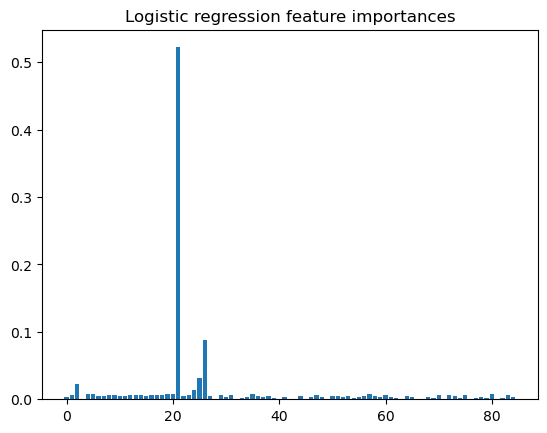

In [73]:
# plot feature importances
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_);
plt.title('Logistic regression feature importances');
plt.show();
plt.savefig('figures/lr_features');

In [54]:
# find most important feature
columns[np.argmax(xgb.feature_importances_)]

'Outpatient'

In [74]:
# run XGB model on only outpatient data
outpatient_data = full_train[full_train['Outpatient']==1]

X = outpatient_data[columns]
y = outpatient_data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# XGB 
xgb = XGBClassifier().fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
accuracy = accuracy_score(y_train, xgb_preds)

print(accuracy)
precision_recall_fscore_support(y_train, xgb_preds, average='macro')

0.6548209937750553


(0.7243076020970721, 0.542451009209667, 0.479417619953127, None)

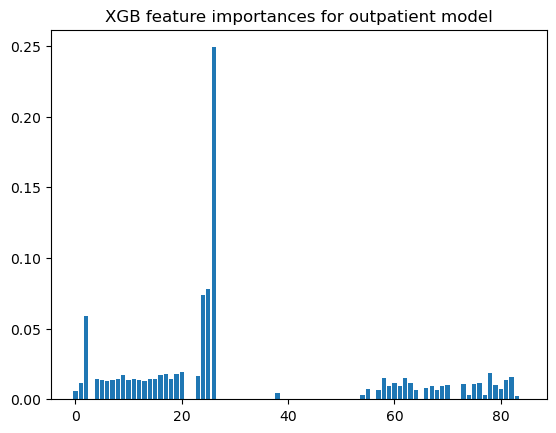

In [75]:
# plot feature importances
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.title('XGB feature importances for outpatient model');
plt.show();
plt.savefig('figures/xgb_outpatient_features');

In [10]:
# find most important feature
columns[np.argmax(xgb.feature_importances_)]

'Race3'

In [76]:
# run XGB model on only inpatient data
inpatient_data = full_train[full_train['Outpatient']==0]

X = inpatient_data[columns]
y = inpatient_data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# XGB 
xgb = XGBClassifier().fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
accuracy = accuracy_score(y_train, xgb_preds)

print(accuracy)
precision_recall_fscore_support(y_train, xgb_preds, average='macro')

0.7309674057778035


(0.7692761969640396, 0.6944216204301505, 0.6941771290868316, None)

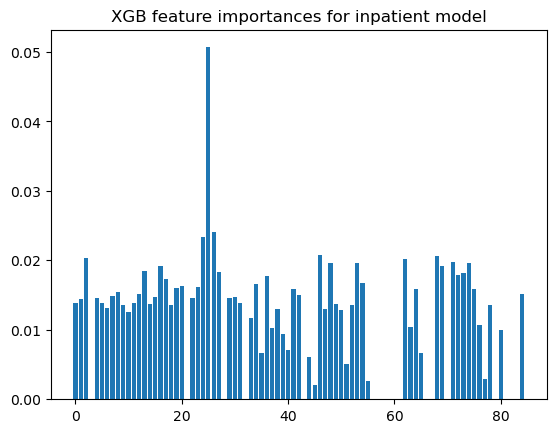

In [77]:
# plot feature importances
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.title('XGB feature importances for inpatient model');
plt.show();
plt.savefig('figures/xgb_inpatient_features');

In [63]:
# find most important feature
columns[np.argmax(xgb.feature_importances_)]

'Clm5123.0'

In [22]:
# are there more instances of the same provider assigning code 5123 among fraudulent providers?
inpatient_data[(inpatient_data['Clm5123.0']==1) & (inpatient_data['Label']==1)]['Provider'].value_counts().values

array([7, 6, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [20]:
# are there less instances of the same provider assigning code 5123 among non fraudulent providers?
inpatient_data[(inpatient_data['Clm5123.0']==1) & (inpatient_data['Label']==0)]['Provider'].value_counts().values

array([4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])